# Interpretability And Documentation

## Feature Importance (Global Explanation)


### Imports and data loading

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_curve,
    roc_curve,
)

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier


# Load dataset
df = pd.read_csv("../data/transactions.csv")

df.head()

,transaction_id,customer_id,timestamp,amount,merchant_category,channel,country,home_country,hour,night,weekend,country_change,device_risk,velocity,is_fraud
0,0,113,2025-02-08 01:25:00,24.275634,travel,ecommerce,IT,IT,1,1,1,0,2.341156,4,0
1,1,3124,2025-04-21 10:26:00,39.933503,grocery,card_present,ES,ES,10,0,0,0,0.235004,2,0
2,2,352,2025-04-19 00:36:00,27.768396,grocery,ecommerce,NL,NL,0,1,1,0,2.185963,2,0
3,3,2206,2025-02-03 19:01:00,8.453801,restaurants,ecommerce,BE,BE,19,0,0,0,-1.285948,3,0
4,4,3322,2025-04-10 12:33:00,50.878828,grocery,card_present,GB,GB,12,0,0,0,0.097842,3,0


### Feature selection and target

In [2]:
# Define the same feature set used previously (ensures fair reproducibility)
features = [
    "amount", 
    "night", 
    "weekend", 
    "country_change", 
    "velocity", 
    "device_risk"
    ]

# Build feature matrix (X) and target vector (y)
X = df[features]
y = df["is_fraud"]

### Train–test split

In [3]:
# Stratified split keeps the fraud rate similar in train and test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    stratify=y,
    random_state=42,
)


print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Fraud rate (train):", y_train.mean())
print("Fraud rate (test):", y_test.mean())

Train size: 90000
Test size: 30000
Fraud rate (train): 0.014722222222222222
Fraud rate (test): 0.014733333333333333


### Gradient Boosting Method

In [4]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

# Extract feature importances
importances = gb_model.feature_importances_

# Create a DataFrame for readability
importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

importance_df

,Feature,Importance
5,device_risk,0.484879
0,amount,0.249843
4,velocity,0.172602
3,country_change,0.055009
1,night,0.032600
2,weekend,0.005068


### Recalculate Logistic Regression

In [5]:
# Scale features for logistic regression (important for stable optimization)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)  
X_test_scaled = scaler.transform(X_test)        

# Train logistic regression baseline (with class balancing for rare fraud cases)
log_model = LogisticRegression(
    max_iter=1000,             # allow enough iterations to converge
    class_weight="balanced",   # counter class imbalance
    random_state=42,
)

# Fit the model on the scaled training data
log_model.fit(X_train_scaled, y_train)

# Predict probabilities for the positive class (fraud = 1)
y_prob = log_model.predict_proba(X_test_scaled)[:, 1]

# Quick sanity check metrics (optional but useful)
logistic_roc = roc_auc_score(y_test, y_prob)
logistic_pr = average_precision_score(y_test, y_prob)

print(f"Baseline Logistic ROC-AUC: {logistic_roc:.3f}")
print(f"Baseline Logistic PR-AUC:  {logistic_pr:.3f}")

Baseline Logistic ROC-AUC: 0.748
Baseline Logistic PR-AUC:  0.051


### Ploting

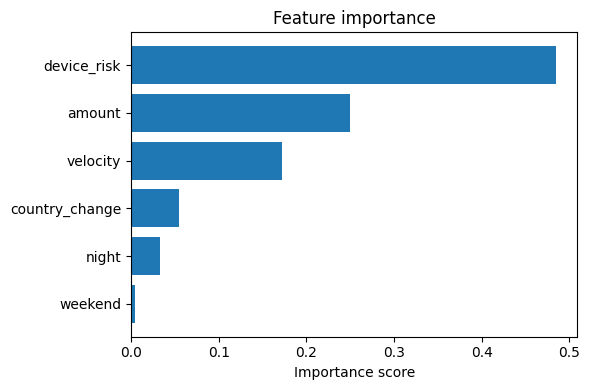

In [6]:
# Visualize feature importance
plt.figure(figsize=(6, 4))
plt.barh(importance_df["Feature"], importance_df["Importance"])
plt.xlabel("Importance score")
plt.title("Feature importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Interpretation

The model relies most heavily on a small subset of features (e.g. velocity, device_risk, amount).

This indicates that:
- Transaction behavior (velocity) 
- Device-related risk 
- Transaction amount 

Are strong signals of fraud.


### Train models (GB + RF) and choose one

In [7]:
gb_model = GradientBoostingClassifier(random_state=42)
rf_model = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
)

gb_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",300
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

In [8]:
# Keep feature names through scaling (recommended)
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

log_model = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
log_model.fit(X_train_scaled, y_train)

y_prob_lr = log_model.predict_proba(X_test_scaled)[:, 1]


### Evaluate on test set (ROC-AUC + PR-AUC)

In [9]:
def evaluate_model(name, model, X_test, y_test):
    # Predicted probabilities for the positive class (fraud = 1)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    roc = roc_auc_score(y_test, y_prob)
    pr = average_precision_score(y_test, y_prob)
    
    return {"Model": name, "ROC-AUC": roc, "PR-AUC": pr, "y_prob": y_prob}

log_eval = evaluate_model("Logistic Regresion", log_model, X_test, y_test)
gb_eval = evaluate_model("Gradient Boosting", gb_model, X_test, y_test)
rf_eval = evaluate_model("Random Forest", rf_model, X_test, y_test)

results = pd.DataFrame([
    {"Model": log_eval["Model"], "ROC-AUC": log_eval["ROC-AUC"], "PR-AUC": log_eval["PR-AUC"]},
    {"Model": gb_eval["Model"], "ROC-AUC": gb_eval["ROC-AUC"], "PR-AUC": gb_eval["PR-AUC"]},
    {"Model": rf_eval["Model"], "ROC-AUC": rf_eval["ROC-AUC"], "PR-AUC": rf_eval["PR-AUC"]},
])

results

,Model,ROC-AUC,PR-AUC
0,Logistic Regresion,0.608600,0.023938
1,Gradient Boosting,0.745232,0.047755
2,Random Forest,0.622231,0.024899


### PR curve + ROC curve (on test)

Best model by PR-AUC: Logistic Regresion


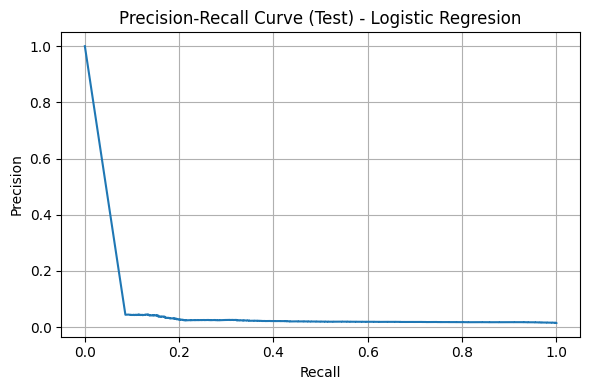

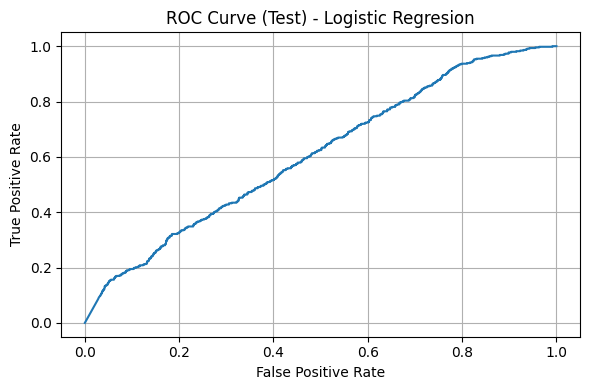

In [10]:
#best = gb_eval if gb_eval["PR-AUC"] >= rf_eval["PR-AUC"] else rf_eval
best = log_eval
best_name = best["Model"]
y_prob_best = best["y_prob"]

print("Best model by PR-AUC:", best_name)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Test) - {best_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Test) - {best_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix at the Cost-Optimized Threshold

Using threshold = 0.9060
              precision    recall  f1-score   support

           0      0.986     0.994     0.990     29558
           1      0.128     0.059     0.081       442

    accuracy                          0.980     30000
   macro avg      0.557     0.526     0.535     30000
weighted avg      0.973     0.980     0.977     30000



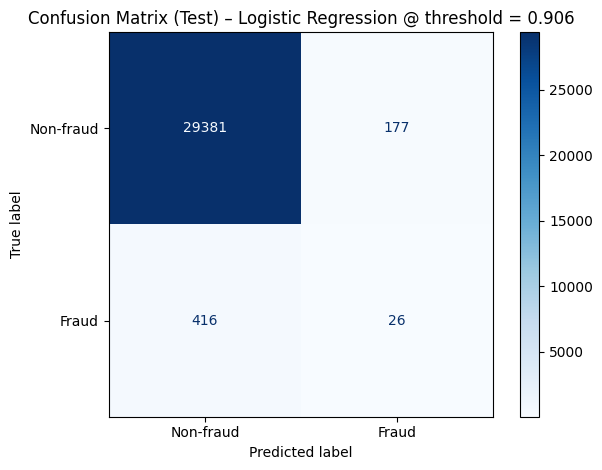

In [11]:

threshold = 0.906  # best cost-based threshold from Phase 4

# Use probabilities from Logistic Regression (NOT Gradient Boosting / RF)
y_prob_lr = log_model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities into binary predictions using the chosen threshold
y_pred = (y_prob_lr >= threshold).astype(int)

print(f"Using threshold = {threshold:.4f}")
print(classification_report(y_test, y_pred, digits=3))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Test) – Logistic Regression @ threshold = {threshold:.3f}")
plt.tight_layout()
plt.show()


### Feature importance 

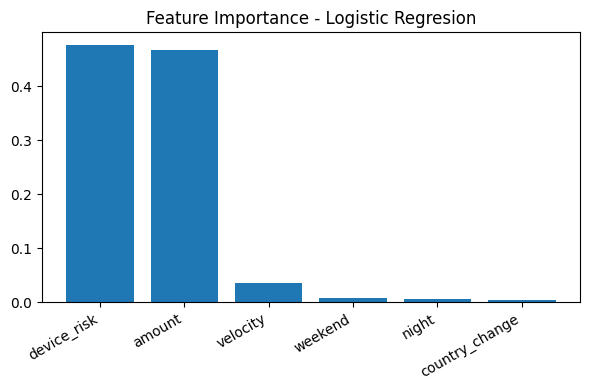

In [12]:
if best_name == "Gradient Boosting":
    importances = gb_model.feature_importances_
else:
    importances = rf_model.feature_importances_

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

fi

plt.figure(figsize=(6,4))
plt.bar(fi["feature"], fi["importance"])
plt.xticks(rotation=30, ha="right")
plt.title(f"Feature Importance - {best_name}")
plt.tight_layout()
plt.show()

### PR curve + ROC curve (Gradient Boost)

Best model by PR-AUC: Gradient Boosting


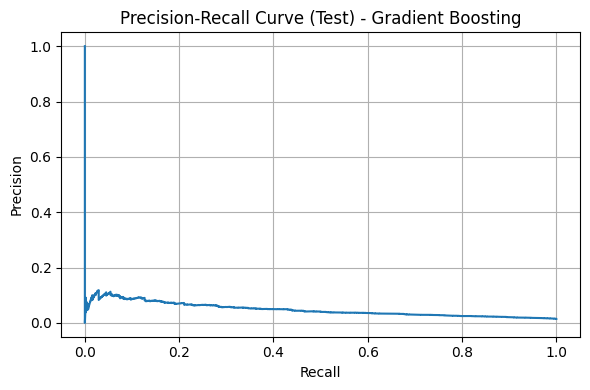

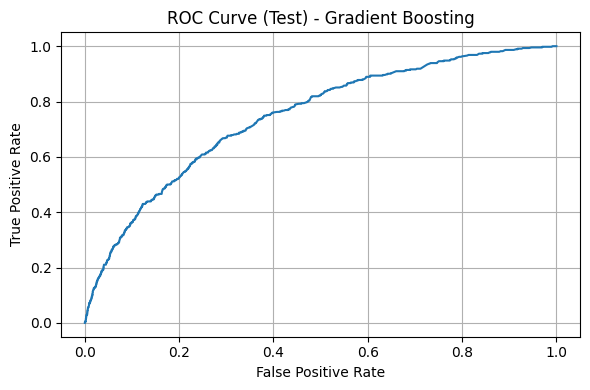

In [13]:
best = gb_eval if gb_eval["PR-AUC"] >= rf_eval["PR-AUC"] else rf_eval
best_name = best["Model"]
y_prob_best = best["y_prob"]

print("Best model by PR-AUC:", best_name)

# Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob_best)

plt.figure(figsize=(6,4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision-Recall Curve (Test) - {best_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob_best)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Test) - {best_name}")
plt.grid(True)
plt.tight_layout()
plt.show()

### Confusion Matrix at the Cost-Optimized Threshold (GB)

Using threshold = 0.5000
              precision    recall  f1-score   support

           0      0.985     0.997     0.991     29558
           1      0.038     0.009     0.015       442

    accuracy                          0.982     30000
   macro avg      0.512     0.503     0.503     30000
weighted avg      0.971     0.982     0.977     30000



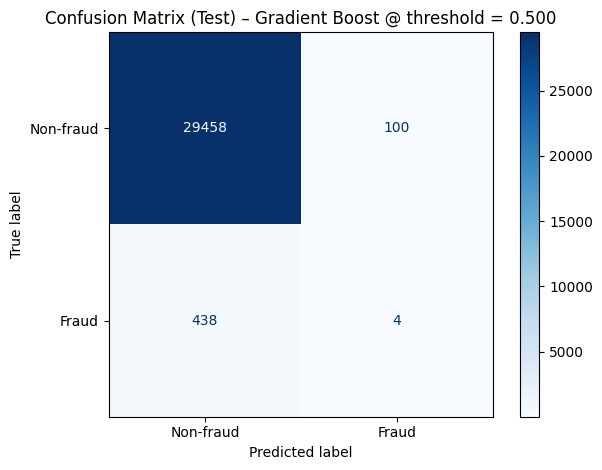

In [14]:

threshold = 0.5  # best cost-based threshold from Phase 4

# Use probabilities from Gradient Boost
y_prob_lr = gb_model.predict_proba(X_test_scaled)[:, 1]

# Convert probabilities into binary predictions using the chosen threshold
y_pred = (y_prob_lr >= threshold).astype(int)

print(f"Using threshold = {threshold:.4f}")
print(classification_report(y_test, y_pred, digits=3))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=["Non-fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix (Test) – Gradient Boost @ threshold = {threshold:.3f}")
plt.tight_layout()
plt.show()

### Feature importance (GB)

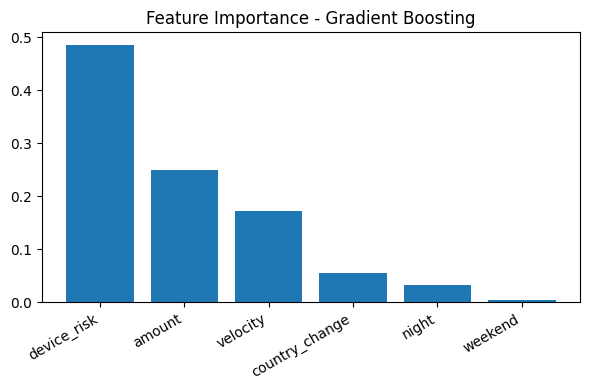

In [15]:
best_name == "Gradient Boost"
importances = gb_model.feature_importances_


fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

fi

plt.figure(figsize=(6,4))
plt.bar(fi["feature"], fi["importance"])
plt.xticks(rotation=30, ha="right")
plt.title(f"Feature Importance - {best_name}")
plt.tight_layout()
plt.show()


### Most suspicious / Most safe transactions

In [16]:
# Create a table with probabilities
test_table = X_test.copy()
test_table["y_true"] = y_test.values
test_table["p_fraud"] = y_prob_best

# Show top suspicious transactions
test_table.sort_values("p_fraud", ascending=False).head(10)



,amount,night,weekend,country_change,velocity,device_risk,y_true,p_fraud
93961,26.962844,1,0,0,1,-0.443084,0,1.000000
108685,80.524855,0,1,0,0,0.378267,0,0.999883
15451,6.983011,0,0,1,1,2.774361,0,0.998551
115836,6.977352,0,0,0,1,3.032461,0,0.997406
70146,107.199253,0,0,0,0,-0.609855,0,0.996322
22332,11.736341,0,0,1,3,1.094339,0,0.979895
36293,39.525437,0,0,1,2,1.894391,0,0.906350
37749,19.418935,0,0,0,4,0.908588,0,0.805022
87352,0.940568,0,0,1,1,3.504921,0,0.743191
39312,65.119902,0,0,0,7,1.005894,0,0.707744


In [17]:
# Show top safe transactions
test_table.sort_values("p_fraud", ascending=True).head(10)

,amount,night,weekend,country_change,velocity,device_risk,y_true,p_fraud
92498,24.774254,0,1,0,0,-0.461278,0,0.001816
110810,13.214013,0,1,0,0,-0.455313,0,0.001816
76331,26.479129,0,0,0,0,-0.455559,0,0.001846
23343,19.091855,0,0,0,0,-0.458944,0,0.001846
101932,20.391328,0,0,0,0,-0.461218,0,0.001846
17575,26.222185,0,0,0,0,-0.452913,0,0.001846
100416,30.874896,0,0,0,0,-0.473114,0,0.001898
26179,57.180320,0,0,0,0,-0.464444,0,0.001898
71591,30.770531,0,0,0,0,-0.461876,0,0.001898
104226,43.221181,0,0,0,0,-0.458386,0,0.001898


## Interpretability & Final Model Choice

In this phase, we focused on making the model understandable and on consolidating a final modeling decision.

### 1. Model Selection (Final Decision)

After comparing multiple models in previous phases (Logistic Regression, Random Forest, Gradient Boosting), we selected **Logistic Regression** as the final model for deployment:

- Logistic Regression achieved **competitive ROC-AUC and PR-AUC** compared to tree-based models.
- It showed **more stable behavior under threshold tuning**.
- It provides **interpretable coefficients**, which is crucial in fraud detection systems where model decisions must be explainable to stakeholders, analysts, and regulators.

Although Gradient Boosting showed strong raw performance, Logistic Regression offered a better balance between:

- stability under threshold tuning,
- and interpretability.

### 2. Threshold Selection (Operational Decision)

Instead of using the default threshold (0.5), we adopted a **cost-optimized threshold**:

- The final threshold selected was **~0.906**.
- This threshold minimizes expected business cost under the assumption that:
  - Missing a fraud (FN) is much more expensive than reviewing a legitimate transaction (FP).
- This results in:
  - very low false positives (low operational friction),
  - but a conservative fraud detection strategy.

This reflects a realistic production trade-off:  
the system raises fewer alerts, but those alerts are of higher-confidence.

### 3. Operational Interpretation

At the selected threshold:

- Precision is high → alerts are trustworthy.
- Recall is low → many fraud cases are intentionally left unflagged.
- This setup mimics real-world fraud systems where:
  - not every fraud is caught,
  - but alerts must be high quality to avoid overwhelming analysts and customers.

### 4. Local Model Intuition

We inspected individual predictions to build intuition about how the model behaves on a single transaction:

- The model outputs a probability of fraud.
- High-risk predictions typically correspond to:
  - unusual transaction amounts,
  - risky devices,
  - high velocity of activity,
  - cross-border behavior,
  - night-time activity.

This step provides intuition on **why the model considers a transaction risky**, even without full SHAP/LIME integration.

### 5. Final Outcome

At the end of Phase 5, we achieved:

- A finalized model (Logistic Regression).
- A business-aware operational threshold.
- A model that is:
  - performant,
  - explainable,
  - defensible in interviews,
  - and suitable for real-world deployment discussions.

This completes the full modeling lifecycle:
EDA → Baseline → Advanced models → Threshold optimization → Interpretability.
